In [1]:
import numpy as np
import random as rnd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as scp
import pandas as pd

from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit

sns.set(style="ticks", context='poster')
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as patches
%matplotlib inline

# Figure S1

In [2]:
# Load holey RNA model results
RNA_holey = pd.read_csv('./RNA_holey_results.csv')

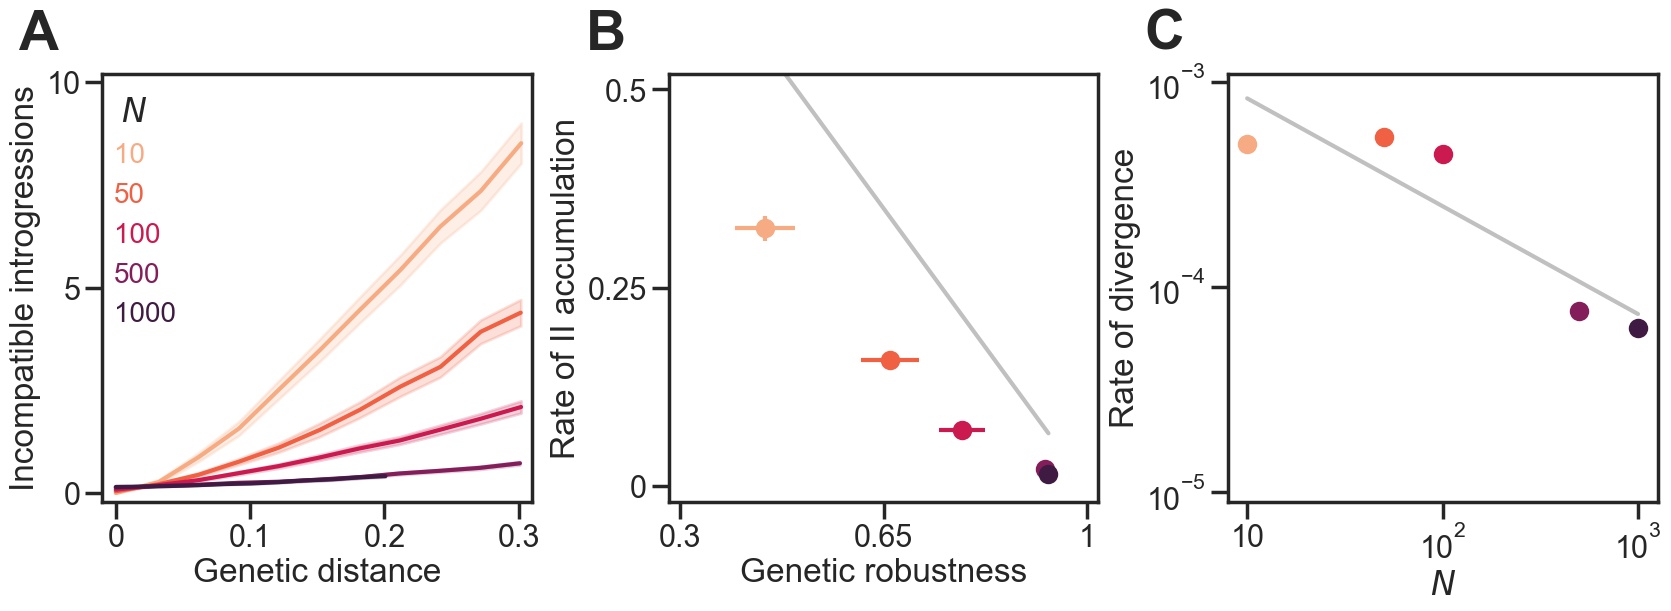

In [3]:
fig, axes = plt.subplots(
    nrows=1,
    ncols=3,
    figsize=(16.6, 6), constrained_layout=True)


axes = axes.flatten()

N_pops = [10, 50, 100, 500, 1000]

fits = pd.DataFrame()
count = 0
for N in N_pops:
    new_data = RNA_holey[(RNA_holey['N']==N)&(RNA_holey['r']=='Free')]
    reps = np.unique(new_data['Sim'])
    for j in reps: 
        x = np.array(new_data[new_data['Sim']==j]['D'])[1:].reshape(-1, 1)
        y = np.array(new_data[new_data['Sim']==j]['II'])[1:]
        model = LinearRegression()
        model.fit(x,y)
        temp = pd.DataFrame.from_dict({'ID': [count], 'N': [N], 'slope': [model.coef_[0]], 'intercept': [model.intercept_]})
        fits = pd.concat([fits, temp])
        count += 1

count = 0
for N in N_pops:
    new_data = RNA_holey[(RNA_holey['N']==N)&(RNA_holey['r']=='Free')]
    x_data = new_data.groupby('stp')['D'].mean()
    y_data = new_data.groupby('stp')['II'].mean()
    err = 1.96* new_data.groupby('stp')['II'].std()/np.sqrt(len(new_data)/len(x_data))
    if N == 1000:
        clip_threshold = 0.21
    else:
        clip_threshold = 0.31
    # Mask the values that exceed the threshold
    err_masked = np.ma.masked_where(x_data > clip_threshold, err)
    x_masked = np.ma.masked_where(x_data > clip_threshold, x_data)
    y_masked = np.ma.masked_where(x_data > clip_threshold, y_data)
    axes[0].errorbar(x_masked, y_masked, fmt='-', linewidth=3, capsize=0, markersize=12, clip_on=True, color=sns.color_palette('rocket_r', n_colors=len(N_pops))[count], label=N)
    axes[0].fill_between(x_masked, y_masked - err_masked, y_masked + err_masked, alpha=0.2, color=sns.color_palette('rocket_r', n_colors=len(N_pops))[count])
    count += 1
    
exp_II = []
robs = []
for N in N_pops:
    new_data = RNA_holey[(RNA_holey['N']==N)&(RNA_holey['r']=='Free')]
    exp_II.append(1 - np.mean(new_data.groupby('stp')['nu'].mean()))
    robs.append(np.mean(new_data.groupby('stp')['nu'].mean()))
axes[1].plot(robs, exp_II, color='silver', zorder=0)
    


lg = axes[0].legend(loc=(-0.05,0.38), frameon=False, markerscale=0, handlelength=0, handleheight=0.1, labelcolor='linecolor', prop={'weight':'normal', 'size':'small'}, title=r'$\it{N}$')

count = 0
for N in N_pops:
    new_data = RNA_holey[(RNA_holey['N']==N)&(RNA_holey['r']=='Free')]
    new_data_fit = fits[fits['N']==N]
    y_data = np.mean(new_data_fit['slope'])
    err = 1.96*np.std(new_data_fit['slope'])/np.sqrt(len(new_data_fit))
    y_data = y_data/100.
    err = err/100.
    err_rob = 1.96*np.mean(new_data.groupby('stp')['nu'].std())/np.sqrt(len(new_data.groupby('stp')['nu'].mean()))
    axes[1].scatter(np.mean(new_data.groupby('stp')['nu'].mean()), y_data, clip_on=True, color=sns.color_palette('rocket_r', n_colors=len(N_pops))[count], zorder=count)
    axes[1].vlines(np.mean(new_data.groupby('stp')['nu'].mean()), y_data - err, y_data + err, color=sns.color_palette('rocket_r', n_colors=len(N_pops))[count], zorder=count)
    axes[1].hlines(y_data, np.mean(new_data.groupby('stp')['nu'].mean()) - err_rob, np.mean(new_data.groupby('stp')['nu'].mean()) + err_rob, color=sns.color_palette('rocket_r', n_colors=len(N_pops))[count])
    count += 1
axes[1].set_ylabel(r'Rate of II accumulation')
axes[1].set_xlabel(r'Genetic robustness')


fits_div = pd.DataFrame()
count = 0
for N in N_pops:
    new_data = RNA_holey[(RNA_holey['N']==N)&(RNA_holey['r']=='Free')]
    reps = np.unique(new_data['Sim'])
    for j in reps: 
        x = np.array(new_data[new_data['Sim']==j]['gen'])[1:].reshape(-1, 1)
        y = np.array(new_data[new_data['Sim']==j]['D'])[1:]
        model = LinearRegression()
        model.fit(x,y)
        temp = pd.DataFrame.from_dict({'ID': [count], 'N': [N], 'slope': [model.coef_[0]], 'intercept': [model.intercept_]})
        fits_div = pd.concat([fits_div, temp])
        count += 1
        
fits = []
for N in N_pops:
    new_data_fit = fits_div[fits_div['N']==N]
    fits.append(np.mean(new_data_fit['slope']))
model = LinearRegression()
model.fit(np.log(N_pops).reshape(-1, 1), np.log(fits))
axes[2].plot(N_pops, [np.exp(model.coef_[0]*i +  model.intercept_) for i in np.log(N_pops)], color='silver', zorder=0)

count = 0
for N in N_pops:
    new_data = RNA_holey[(RNA_holey['N']==N)&(RNA_holey['r']=='Free')]
    new_data_fit = fits_div[fits_div['N']==N]
    y_data = np.mean(new_data_fit['slope'])
    err = 1.96*np.std(new_data_fit['slope'])/np.sqrt(len(new_data_fit))
    axes[2].scatter(N, y_data, clip_on=True, color=sns.color_palette('rocket_r', n_colors=len(N_pops))[count], zorder=count+1)
    axes[2].vlines(N, y_data - err, y_data + err, color=sns.color_palette('rocket_r', n_colors=len(N_pops))[count], zorder=count+1)
    count += 1
    
axes[2].set_xscale('log')
axes[2].set_yscale('log')

axes[2].set_ylabel(r'Rate of divergence')
axes[2].set_xlabel(r'$N$')
axes[2].set_ylim(0.9e-5, 1.1e-3)
axes[2].minorticks_off()

axes[2].set_xticks([10, 100, 1000])
axes[2].set_xticklabels(['$\\mathdefault{10}$','$\\mathdefault{10^{2}}$','$\\mathdefault{10^{3}}$'])


for i, label in enumerate(('A', 'B', 'C')):
    axes[i].text(-0.1, 1.15, label, transform=axes[i].transAxes,fontsize=40, fontweight='bold', va='top', ha='right')

    
axes[0].set_ylim(-0.2, 10.2)
axes[0].set_xlim(-0.01, 0.31)
axes[0].set_xticks(np.linspace(0, 0.3, 4))
axes[0].set_xticklabels([0, 0.1, 0.2, 0.3])
axes[0].set_ylabel('Incompatible introgressions')
axes[0].set_xlabel(r'Genetic distance')
axes[0].set_yticks(np.linspace(0, 10, 3))

axes[1].set_ylim(-0.02, 0.52)
axes[1].set_xlim(0.28, 1.02)
axes[1].set_xticks(np.linspace(0.3, 1, 3))
axes[1].set_yticks(np.linspace(0., 0.5, 3))
axes[1].set_xticklabels([0.3, 0.65, 1])
axes[1].set_yticklabels([0, 0.25, 0.5])

lg.get_title().set_position((0, 0))
plt.savefig('./FigS1.svg', bbox_inches='tight', dpi=100);

# Figure S2

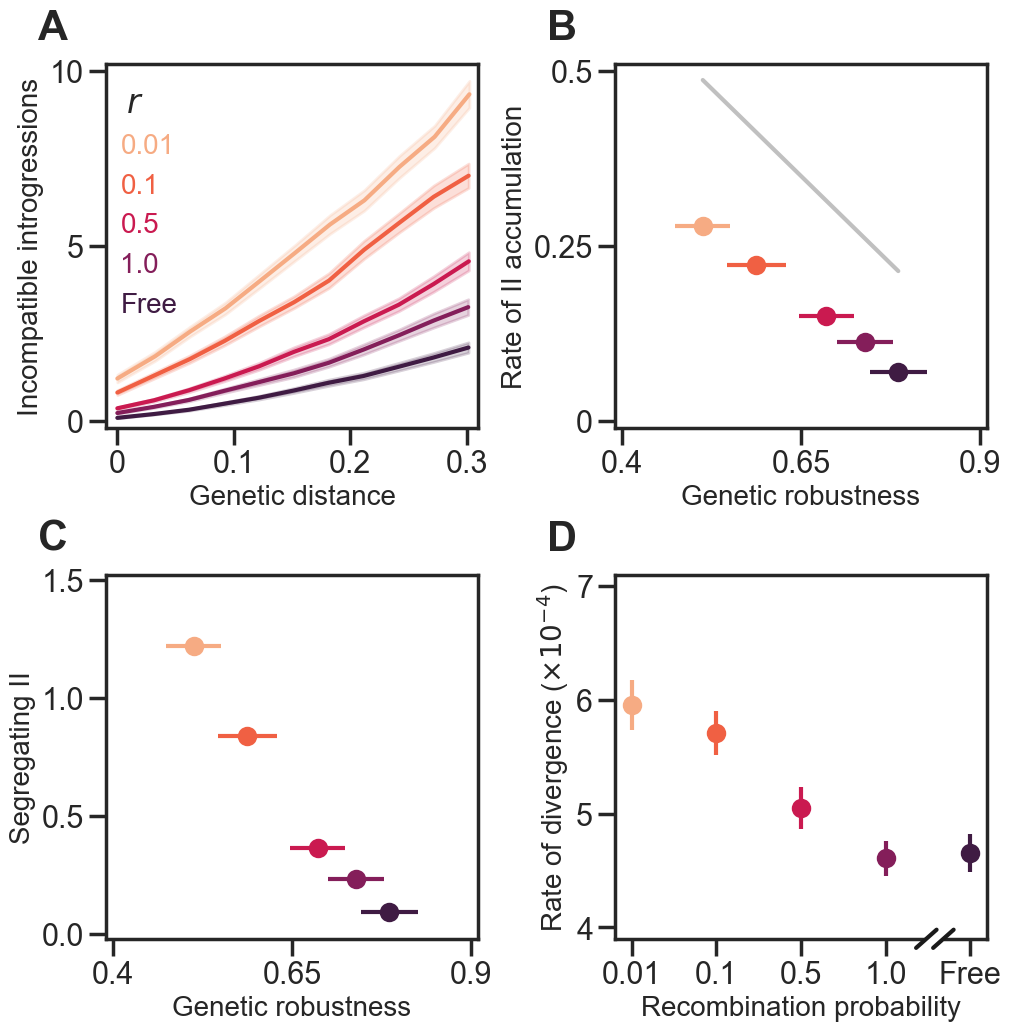

In [5]:
fig, axes = plt.subplots(
    nrows=2,
    ncols=2,
    figsize=(10, 10.2), constrained_layout=True)

axes = axes.flatten()

r_pops = ['0.01', '0.1', '0.5', '1.0', 'Free']

fits = pd.DataFrame()
count = 0
for r in r_pops:
    new_data = RNA_holey[(RNA_holey['N']==100)&(RNA_holey['r']==r)]
    reps = np.unique(new_data['Sim'])
    for j in reps: 
        x = np.array(new_data[new_data['Sim']==j]['D'])[1:].reshape(-1, 1)
        y = np.array(new_data[new_data['Sim']==j]['II'])[1:]
        model = LinearRegression()
        model.fit(x,y)
        temp = pd.DataFrame.from_dict({'ID': [count], 'r': [r], 'slope': [model.coef_[0]], 'intercept': [model.intercept_]})
        fits = pd.concat([fits, temp])
        count += 1

count = 0
for r in r_pops:
    new_data = RNA_holey[(RNA_holey['N']==100)&(RNA_holey['r']==r)]
    x_data = new_data.groupby('stp')['D'].mean()
    y_data = new_data.groupby('stp')['II'].mean()
    err = 1.96* new_data.groupby('stp')['II'].std()/np.sqrt(len(new_data)/len(x_data))
    clip_threshold = 0.31
    # Mask the values that exceed the threshold
    err_masked = np.ma.masked_where(x_data > clip_threshold, err)
    x_masked = np.ma.masked_where(x_data > clip_threshold, x_data)
    y_masked = np.ma.masked_where(x_data > clip_threshold, y_data)
    axes[0].errorbar(x_masked, y_masked, fmt='-', linewidth=3, capsize=0, markersize=12, clip_on=True, color=sns.color_palette('rocket_r', n_colors=len(N_pops))[count], label=r)
    axes[0].fill_between(x_masked, y_masked - err_masked, y_masked + err_masked, alpha=0.2, color=sns.color_palette('rocket_r', n_colors=len(N_pops))[count])
    count += 1

handles, labels = axes[0].get_legend_handles_labels()

count = 0
for r in r_pops:
    new_data = RNA_holey[(RNA_holey['N']==100)&(RNA_holey['r']==r)]
    new_data_fit = fits[fits['r']==r]
    y_data = np.mean(new_data_fit['slope'])
    err = 1.96*np.std(new_data_fit['slope'])/np.sqrt(len(new_data_fit))
    y_data = y_data/100.
    err = err/100.
    err_rob = 1.96*np.mean(new_data.groupby('stp')['nu'].std())/np.sqrt(len(new_data.groupby('stp')['nu'].mean()))
    axes[1].scatter(np.mean(new_data.groupby('stp')['nu'].mean()), y_data, clip_on=True, color=sns.color_palette('rocket_r', n_colors=len(r_pops))[count])
    axes[1].vlines(np.mean(new_data.groupby('stp')['nu'].mean()), y_data - err, y_data + err, color=sns.color_palette('rocket_r', n_colors=len(r_pops))[count])
    axes[1].hlines(y_data, np.mean(new_data.groupby('stp')['nu'].mean()) - err_rob, np.mean(new_data.groupby('stp')['nu'].mean()) + err_rob, color=sns.color_palette('rocket_r', n_colors=len(r_pops))[count])
    count += 1



exp_II = []
robs = []
for r in r_pops:
    new_data = RNA_holey[(RNA_holey['N']==100)&(RNA_holey['r']==r)]
    exp_II.append(1 - np.mean(new_data.groupby('stp')['nu'].mean()))
    robs.append(np.mean(new_data.groupby('stp')['nu'].mean()))
axes[1].plot(robs, exp_II, color='silver', zorder=0)

count = 0
for r in r_pops:
    new_data = RNA_holey[(RNA_holey['N']==100)&(RNA_holey['r']==r)]
    y_data = np.mean(new_data.groupby('stp')['segII'].mean())
    err = 1.96*np.std(new_data['segII'])/np.sqrt(len(new_data['segII']))
    err_rob = 1.96*np.mean(new_data.groupby('stp')['nu'].std())/np.sqrt(len(new_data.groupby('stp')['nu'].mean()))
    axes[2].scatter(np.mean(new_data.groupby('stp')['nu'].mean()), y_data, clip_on=True, color=sns.color_palette('rocket_r', n_colors=len(r_pops))[count])
    axes[2].vlines(np.mean(new_data.groupby('stp')['nu'].mean()), y_data - err, y_data + err, color=sns.color_palette('rocket_r', n_colors=len(r_pops))[count])
    axes[2].hlines(y_data, np.mean(new_data.groupby('stp')['nu'].mean()) - err_rob, np.mean(new_data.groupby('stp')['nu'].mean()) + err_rob, color=sns.color_palette('rocket_r', n_colors=len(r_pops))[count])
    count += 1

count = 0

fits_div = pd.DataFrame()
count = 0
for r in r_pops:
    new_data = RNA_holey[(RNA_holey['N']==100)&(RNA_holey['r']==r)]
    reps = np.unique(new_data['Sim'])
    for j in reps: 
        x = np.array(new_data[new_data['Sim']==j]['gen']).reshape(-1, 1)
        y = np.array(new_data[new_data['Sim']==j]['D'])
        model = LinearRegression()
        model.fit(x,y)
        temp = pd.DataFrame.from_dict({'ID': [count], 'r': [r], 'slope': [model.coef_[0]], 'intercept': [model.intercept_]})
        fits_div = pd.concat([fits_div, temp])
        count += 1

count = 0
for r in r_pops:
    new_data = RNA_holey[(RNA_holey['N']==100)&(RNA_holey['r']==r)]
    new_data_fit = fits_div[fits_div['r']==r]
    y_data = np.mean(new_data_fit['slope'])
    err = 1.96*np.std(new_data_fit['slope'])/np.sqrt(len(new_data_fit))
    axes[3].scatter(count, y_data, clip_on=True, color=sns.color_palette('rocket_r', n_colors=len(r_pops))[count], zorder=count)
    axes[3].vlines(count, y_data - err, y_data + err, color=sns.color_palette('rocket_r', n_colors=len(r_pops))[count], zorder=count)
    count += 1
    
axes[3].add_patch(patches.Rectangle((3.48, 3.85e-4), 0.19, 1e-5, color="white", fill=True, clip_on=False, zorder=9))

d = 0.025  # line length 
axes[3].plot((0.84-d - 0.0058, 0.845+d - 0.0058), (-d, +d), c='k',linewidth=3, clip_on=False, transform=axes[3].transAxes, zorder=10)
axes[3].plot((0.84-d +0.04, 0.845+d+0.04), (-d, +d), c='k',linewidth=3, clip_on=False, transform=axes[3].transAxes, zorder=10)

for i, label in enumerate(('A', 'B', 'C', 'D')):
    axes[i].text(-0.1, 1.15, label, transform=axes[i].transAxes,fontsize=30, fontweight='bold', va='top', ha='right')


lg = axes[0].legend(loc=(-0.05,0.27), frameon=False, markerscale=0, handlelength=0, handleheight=0.1, labelcolor='linecolor', prop={'weight':'normal', 'size':'small'},title=r'$\it{r}$')
lg.get_title().set_position((-3, 0))


    
axes[0].set_ylim(-0.2, 10.2)
axes[0].set_yticks(np.linspace(0, 10, 3))
axes[0].set_ylabel('Incompatible introgressions', fontsize=20)
axes[0].set_xlabel(r'Genetic distance', fontsize=20)
axes[0].set_xlim(-0.01, 0.31)
axes[0].set_xticks(np.linspace(0, 0.3, 4))
axes[0].set_xticklabels([0, 0.1, 0.2, 0.3])

axes[1].set_yticks(np.linspace(0, 0.5, 3))
axes[1].set_yticklabels([0,  0.25, 0.5])
axes[1].set_ylabel(r'Rate of II accumulation', fontsize=20)
axes[1].set_xlabel(r'Genetic robustness', fontsize=20)
axes[1].set_ylim(-0.01, 0.51)
axes[1].set_xlim(0.39, 0.91)
axes[1].set_xticks(np.linspace(0.4, 0.9, 3))
axes[1].set_xticklabels([0.4, 0.65, 0.9])

axes[2].set_ylabel(r'Segregating II', fontsize=20)
axes[2].set_xlabel(r'Genetic robustness', fontsize=20)
axes[2].set_ylim(-0.02, 1.52)
axes[2].set_xlim(0.39, 0.91)
axes[2].set_xticks(np.linspace(0.4, 0.9, 3))
axes[2].set_xticklabels([0.4, 0.65, 0.9])


axes[3].set_ylabel(r'$N_e$', fontsize=20)
axes[3].set_xlabel(r'Recombination probability', fontsize=20)
axes[3].set_xticks([0, 1, 2, 3, 4])
axes[3].set_xticklabels(r_pops)
axes[3].set_ylabel(r'Rate of divergence ($\times 10^{-4}$)', fontsize=20)

axes[3].set_ylim(0.00039, 0.00071)

axes[3].set_yticks([0.0004, 0.0005, 0.0006, 0.0007])
axes[3].set_yticklabels([4, 5, 6, 7])

    
plt.savefig('./FigS2.svg', bbox_inches='tight', dpi=100);